In [2]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)
import hist as hist2

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot
from coffea import processor
import warnings

warnings.filterwarnings('ignore')

In [14]:
class triggerEffWbProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'pt_m_tr': hist2.Hist(
                hist2.axis.Regular(28, 100, 500, name='pt_m_tr'),
                ),
            'pt_m_tc': hist2.Hist(
                hist2.axis.Regular(28, 100, 500, name='pt_m_tc'),
                ),
            'eta_m_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.4, 2.4, name='eta_m_tr'),
                ),
            'eta_m_tc': hist2.Hist(
                hist2.axis.Regular(50,-2.4, 2.4, name='eta_m_tc'),
                ),
            'met_tr': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tr'),
                ),
            'met_tc': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tc'),
                ),
            'pt_bjet_tr': hist2.Hist(
                hist2.axis.Regular(33, 30, 500, name='pt_bjet_tr'),
                ),
            'pt_bjet_tc': hist2.Hist(
                hist2.axis.Regular(33, 30, 500, name='pt_bjet_tc'),
                ),
            'eta_bjet_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tr'),
                ),
            'eta_bjet_tc': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tc'),
                )
        }
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata['dataset']
        #weights = Weights(len(events), storeIndividual=True)
        #weights.add('genweight', events.genWeight)
        
        selection = PackedSelection()
        
        output =self.make_output()
        output['sum'] = len(events)
        b_jet=events.Jet[events.Jet.btagDeepFlavB>0.4506]
        events["bjet"]=b_jet
        
        #trigger
        
        #trigger_de_ref=events.HLT.Ele35_WPTight_Gsf
        #Muon_mediumId = events.Muon.mediumId == True
        #events["Muon_mediumId"] = Muon_mediumId
        #trigger_central_electron=events.HLT.Ele35_WPTight_Gsf

        trigger_central=events.HLT.Mu50
        
        events["heepmuon"]=events.Muon[events.Muon.mediumId]
        
        #Muon
        
        goodmuon = ((ak.sum(events.heepmuon.pt>0, axis=1)==2)
                &((ak.pad_none(events.Muon.pt,2)[:,0]>30) & (ak.pad_none(events.Muon.pt,2)[:,1]>30))
                & ((abs(ak.pad_none(events.Muon.eta,2)[:,0])<2.4) & (abs(ak.pad_none(events.Muon.eta,2)[:,1])<2.4)))
        
        events["heeplecton"]=events.Electron[events.Electron.cutBased_HEEP]
                       
        #electron
        '''goodelectron = ((ak.sum(events.heeplecton.pt>0, axis=1)==1)
                        &((ak.pad_none(events.heeplecton.pt, 1)[:,0]>30))
                        &(((0<abs(ak.firsts(events.heeplecton.eta))) & (abs(ak.firsts(events.heeplecton.eta))<2.4))
                        & ((1.57<abs(ak.firsts(events.heeplecton.eta))) | (abs(ak.firsts(events.heeplecton.eta))<1.4)))
                #&((ak.pad_none(events.Electron.charge, 2)[:,0])!=(ak.pad_none(events.Electron.charge, 2)[:,1]))
                )'''
        
        #b-jet
        
        goodbJets = ((ak.sum(events.bjet.pt>0, axis=1)==1)
            &((ak.pad_none(events.bjet.pt,1)[:,0]>30)
            &(abs(ak.firsts(events.bjet.eta))<2.1)
             ))
        
        #met
        
        #goodMet=events.MET.pt>50
        
        #seleccion
        
        #selection.add("trigger_de_ref",trigger_de_ref)
        selection.add("trigger_central",trigger_central)
        #selection.add("trigger_central_electron", trigger_central_electron)
        selection.add("muon",goodmuon)
        selection.add("bJet",goodbJets)
        #selection.add("electron",goodelectron)
        #selection.add("Met",goodMet)
        
        #regions
        
        
        regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","muon"],
         "signal_trigger_e_bjet":["trigger_de_ref","muon","bJet"],
         "signal_triggerref_e_bjet_met":["muon","bJet"],
         "signal_triggerctl_e_bjet_met":["muon","bJet","trigger_central"],
                }
        
        #candidates
        
        candidtae_events_ref=events[selection.all(*regions["signal_triggerref_e_bjet_met"])]
        candidtae_events_ctl=events[selection.all(*regions["signal_triggerctl_e_bjet_met"])]
        
        
            
        #selection out
        # pt e
        output['pt_m_tr'].fill(pt_m_tr = ak.firsts(candidtae_events_ref.heepmuon.pt))
        output['pt_m_tc'].fill(pt_m_tc = ak.firsts(candidtae_events_ctl.heepmuon.pt))
        
        #eta e
        output['eta_m_tr'].fill(eta_m_tr = ak.firsts(candidtae_events_ref.heepmuon.eta))
        output['eta_m_tc'].fill(eta_m_tc = ak.firsts(candidtae_events_ctl.heepmuon.eta))
        
        #Met
        #output['met_tr'].fill(met_tr = candidtae_events_ref.MET.pt)
        #output['met_tc'].fill(met_tc = candidtae_events_ctl.MET.pt)
        
        #pt bjet
        output['pt_bjet_tr'].fill(pt_bjet_tr = ak.firsts(candidtae_events_ref.bjet.pt))
        output['pt_bjet_tc'].fill(pt_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.pt))
        
        #eta bjet
        
        output['eta_bjet_tr'].fill(eta_bjet_tr = ak.firsts(candidtae_events_ref.bjet.eta))
        output['eta_bjet_tc'].fill(eta_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.eta))
        
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator
        

In [15]:
import json

# Opening JSON file
f = open("./fileset/singleelectron.txt")
 
# returns JSON object as
# a dictionary
load_data = json.load(f)

datos=[]

for i in load_data["SingleElectron"]: datos.append("root://xcache/"+i)

In [16]:
len(datos)

272

In [17]:
fileset={'TTT':datos}

In [18]:
out = processor.run_uproot_job(
    fileset,
    treename="Events",
    processor_instance=triggerEffWbProcessor(),
    executor=processor.futures_executor,
    executor_args={
        "schema": processor.NanoAODSchema,
         "workers": 32
        #"client": client,
    },
        
    )

Processing:   0%|          | 0/3515 [00:00<?, ?chunk/s]

In [19]:
out["TTT"]["sum"]

350819620

In [20]:
def get_value(den):
    return den.values()

def get_axis(den):
    return [den.axes.bin(i)[0][0] for i in range(len(den.values())+1)]

In [21]:
def graficar_hist(data,labels,namesave,xmin=0,xmax=600):
    plt.plot(igsize=(12, 4))
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(data.values(),bins=np.array(get_axis(data)),
                 color="black",density=True,label=labels)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    #plt.savefig(namesave)

In [22]:
from hist.intervals import clopper_pearson_interval
def error(num, den):
    return abs(
        clopper_pearson_interval(num.values(), den.values()) - num.values() / den.values()
    )

def graf_eficience(num,den,labels,namesave,bar_error=False,ymin=0.8,ymax=1.03,xmin=0,xmax=600):
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    eficience=np.array(num.values()/den.values())
    bines=np.array(get_axis(num))
    eficience[np.isnan(eficience)] = 0
    hep.histplot(eficience,bins=bines,label=labels)
    
    if bar_error:
        el_err = error(num, den)
        hep.histplot(eficience,bins=bines,yerr=el_err,histtype='errorbar',fmt="ko",
             capsize=3,label="error")    
    
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    #plt.savefig(namesave)
    

In [23]:
pt_m_tr=out["TTT"]["pt_m_tr"]
pt_m_tc=out["TTT"]["pt_m_tc"]

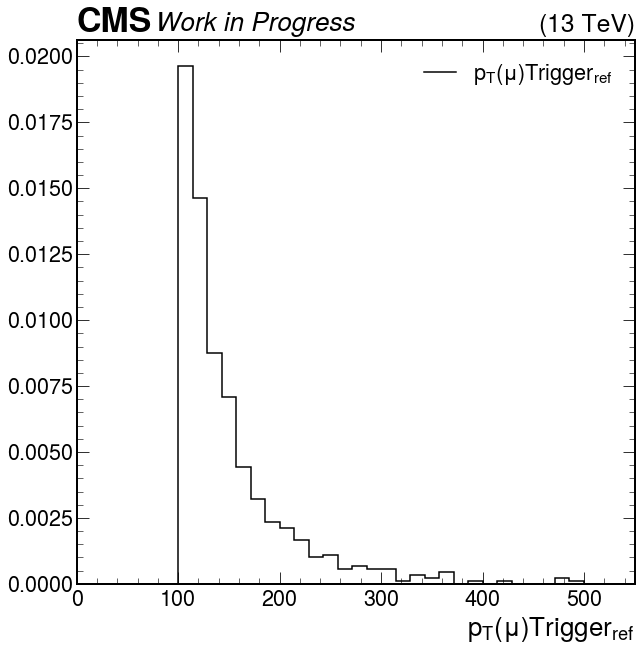

In [24]:
graficar_hist(pt_m_tr,labels="${p}_{T}(\mu) Trigger_{ref}$",
              namesave="./graf_11_02/pt_m_trigger_ref.jpg",
             xmin=0,xmax=550)

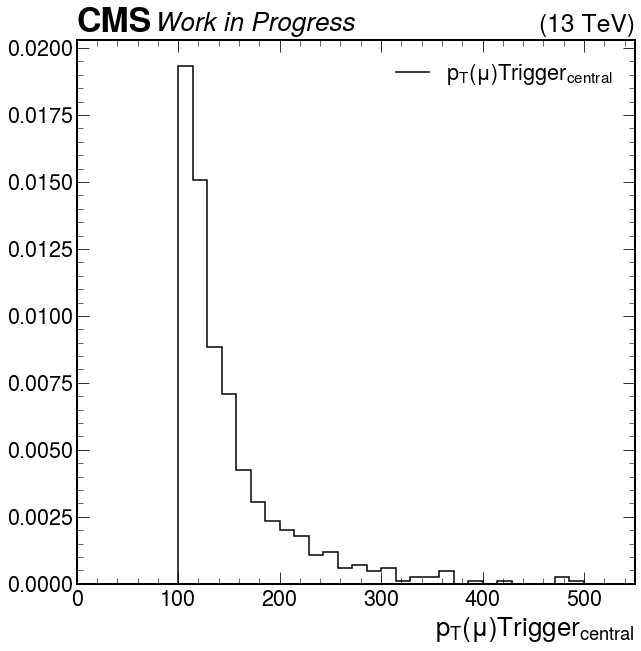

In [25]:
graficar_hist(pt_m_tc,labels="${p}_{T}(\mu) Trigger_{central}$",
              namesave="./graf_11_02/pt_m_trigger_ctl.jpg",
             xmin=0,xmax=550)

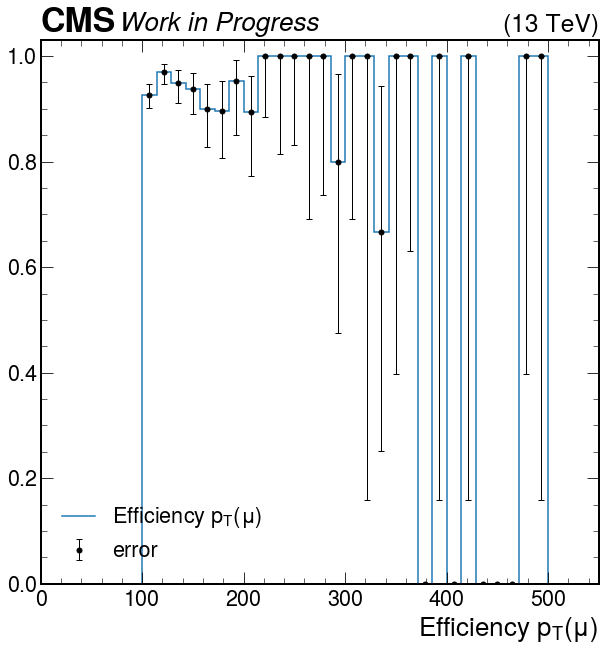

In [26]:
graf_eficience(pt_m_tc,pt_m_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(\mu)$",
               namesave="./graf_11_02/Efficiency_pt_e.jpg",
              xmin=0,xmax=550,ymin=0)

In [27]:
numerador=pt_m_tc.values()
denominador=pt_m_tr.values()
el_err = error(pt_m_tc, pt_m_tr)
bines=np.array(get_axis(pt_m_tc))

In [36]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
dictionary_data = {"numerador_pt_m": numerador, 
                   "denominador_pt_m": denominador,
                   "error":el_err,
                  "bins":bines,}


a_file = open("data_pt_e.json", "w")

json.dump(dictionary_data, a_file,cls=NumpyEncoder)

a_file.close()

In [37]:
eta_m_tr=out["TTT"]["eta_m_tr"]
eta_m_tc=out["TTT"]["eta_m_tc"]

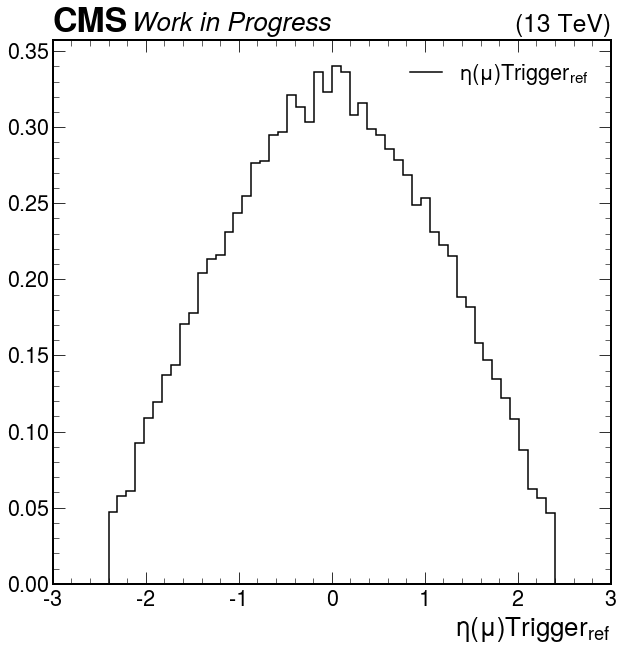

In [38]:
graficar_hist(eta_m_tr,labels="$\eta(\mu) Trigger_{ref}$",
              namesave="./graf_11_02/eta_e_trigger_ref.jpg",
             xmin=-3,xmax=3)

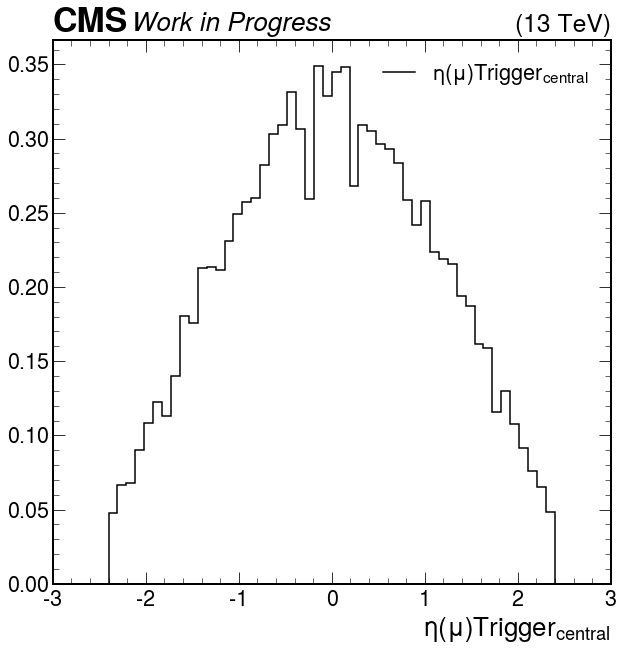

In [39]:
graficar_hist(eta_m_tc,labels="$\eta(\mu) Trigger_{central}$",
              namesave="./graf_11_02/eta_e_trigger_ctl.jpg",
             xmin=-3,xmax=3)

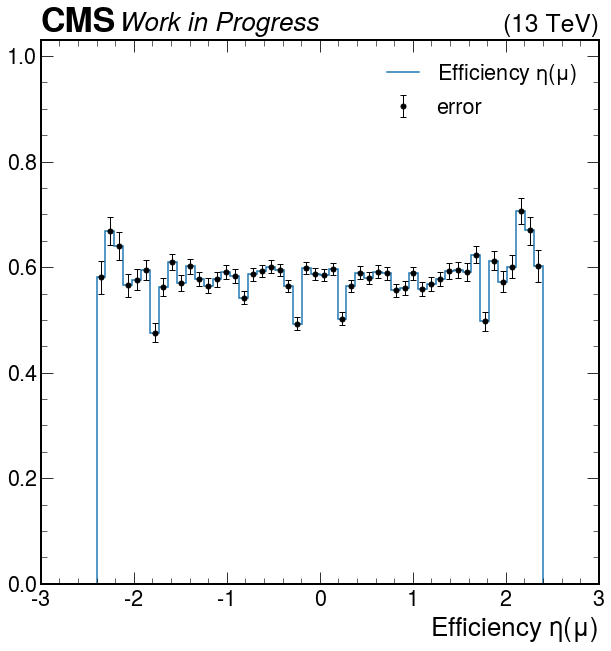

In [40]:
graf_eficience(eta_m_tc,eta_m_tr,bar_error=True,labels="Efficiency $\eta (\mu)$",
               namesave="./graf_11_02/Efficiency_eta_e.jpg",
              xmin=-3,xmax=3,ymin=0)

In [21]:
met_tr=out["TTT"]["met_tr"]
met_tc=out["TTT"]["met_tc"]

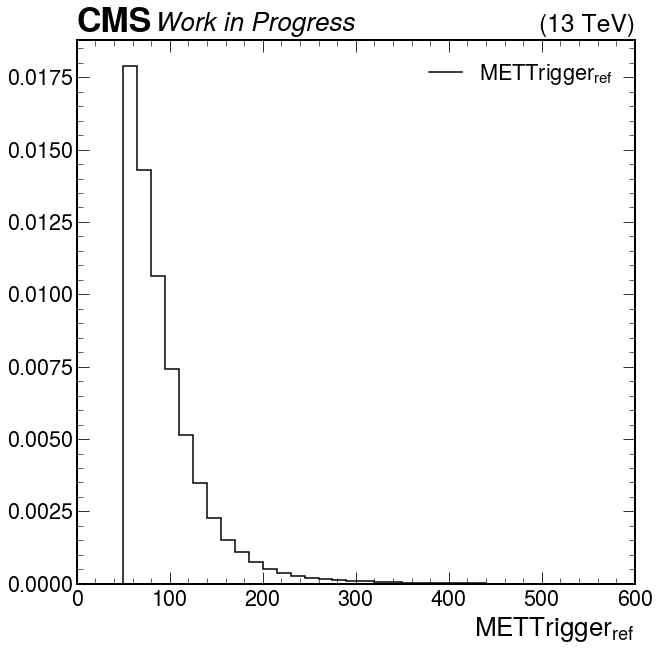

In [23]:
graficar_hist(met_tr,labels="$MET Trigger_{ref}$",
              namesave="./graf_11_02/met_trigger_ref.jpg",
             xmin=0,xmax=600)

In [46]:
pt_bjet_tr=out["TTT"]["pt_bjet_tr"]
pt_bjet_tc=out["TTT"]["pt_bjet_tc"]

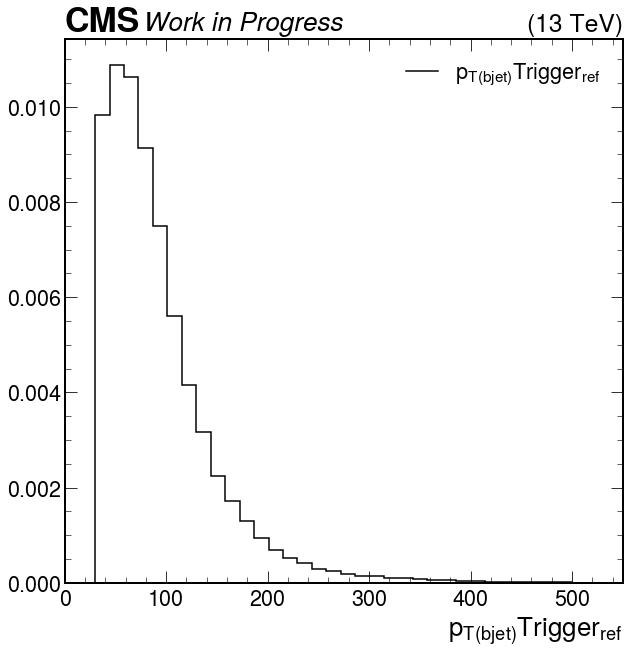

In [47]:
graficar_hist(pt_bjet_tr,labels="${{p}_{T}}_{(bjet)} Trigger_{ref}$",
              namesave="./graf_11_02/pt_bjet_trigger_ref.jpg",
             xmin=0,xmax=550)

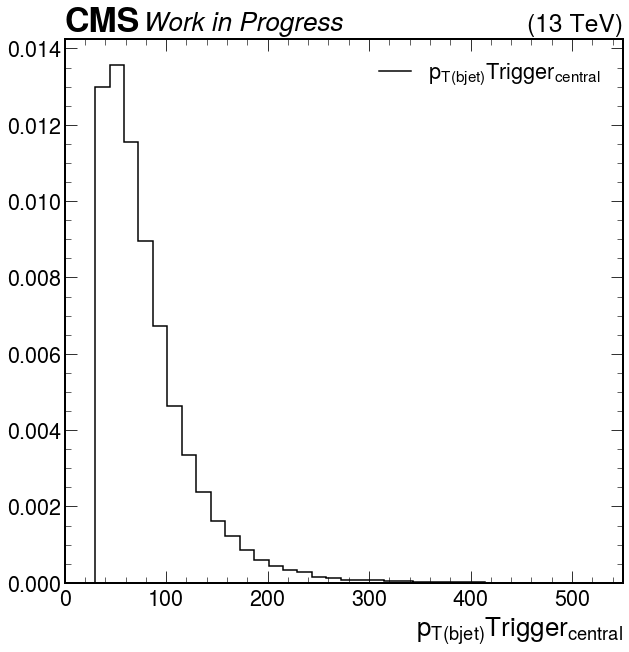

In [48]:
graficar_hist(pt_bjet_tc,labels="${{p}_{T}}_{(bjet)} Trigger_{central}$",
              namesave="./graf_11_02/pt_bjet_trigger_ctl.jpg",
             xmin=0,xmax=550)

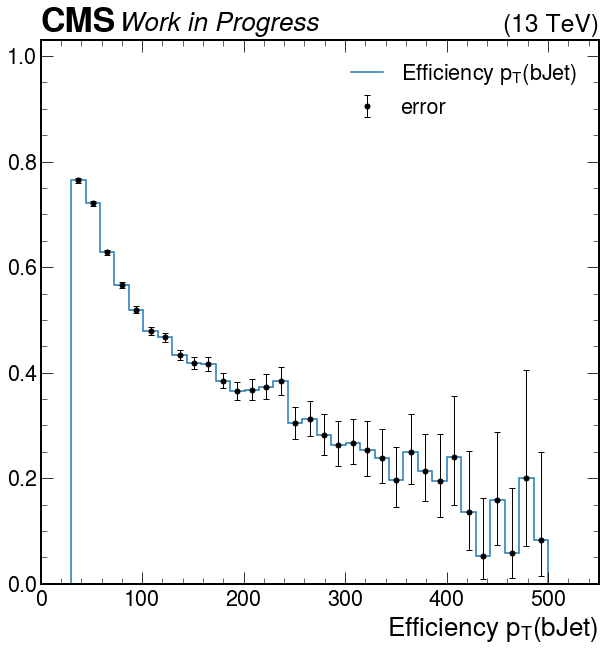

In [45]:
graf_eficience(pt_bjet_tc,pt_bjet_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(bJet)$",
               namesave="./graf_04_03/Efficiency_pt_bjet.jpg",
              xmin=0,xmax=550,ymin=0)